In [1]:
import xarray as xr
import numpy as np
import glob
import json
import boto3
import io

%matplotlib inline

In [2]:
%store -r
# bucket_name = 
# request_id = 
%store

Stored variables and their in-db values:
bucket_name             -> 'eox-masterdatacube'
request_id              -> '601eed9b-9992-4467-8a56-0c510076254c'


In [3]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
userdata_obj = bucket.Object(f'{request_id}/userdata.json')
file_stream = io.BytesIO()
userdata_obj.download_fileobj(file_stream) # load userdata.json into file_stream
userdata = json.loads(file_stream.getvalue())

In [4]:
dss = []
for t in userdata['tiles']:
    arrs = {b: xr.open_rasterio(f's3://{bucket_name}/{request_id}/{t["id"]}/{b}.tif') for b in userdata['bands']}
    dss.append(xr.Dataset(arrs))
ds = xr.combine_by_coords(dss)

In [5]:
ds = ds.rename({'band': 'time'})#, 'y': 'lat', 'x': 'lon'})
ds.coords['time'] = [np.datetime64(t) for t in userdata['time']]
ds

<xarray.Dataset>
Dimensions:  (time: 5, x: 334, y: 334)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-08T11:59:59.500000 ... 2018-09-08T11:59:59.500000
  * y        (y) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.28e+06 5.28e+06 5.28e+06
  * x        (x) float64 6e+05 6.001e+05 6.002e+05 ... 6.199e+05 6.2e+05 6.2e+05
Data variables:
    B03      (time, y, x) uint16 ...
    B04      (time, y, x) uint16 ...
    B05      (time, y, x) uint16 ...
    B08      (time, y, x) uint16 ...
    NDVI     (time, y, x) uint16 ...
    NDWI     (time, y, x) uint16 ...
    CVI      (time, y, x) float32 ...

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


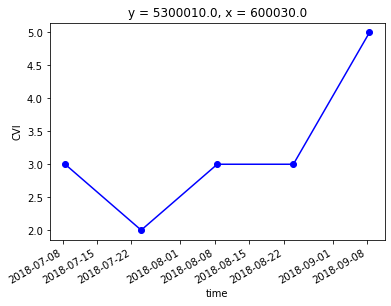

In [6]:
ds.isel(x=0, y=0).CVI.plot.line('b-o')